In [1]:
! pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 56kB/s 


In [2]:
! pip install keras

In [3]:
! pip install pandas

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.1
Hub version: 0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [6]:
#from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D,MaxPooling2D
#from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
#from tensorflow.keras.models import Model
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
#from tensorflow.keras.models import Sequential
#from glob import glob

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error


In [7]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, r2_score
import os
import cv2

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
file="/content/drive/My Drive/Colab Notebooks/IBM_2006-01-01_to_2018-01-01.csv"


In [14]:
import pandas as pd
df=pd.read_csv(file,index_col='Date', parse_dates=['Date'])
df

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
...,...,...,...,...,...,...
2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM


In [15]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')

In [16]:
df.shape

(3020, 6)

In [17]:
df.isnull().sum()

Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [19]:
df.dropna(inplace=True)

In [20]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [61]:
df.shape

(3019, 6)

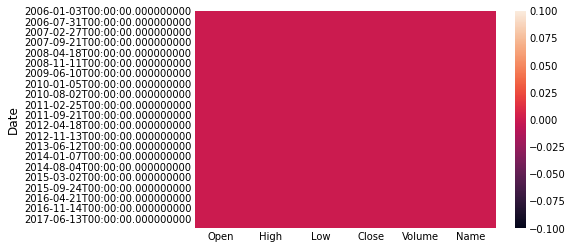

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.heatmap(df.isnull())

In [55]:
# Checking for missing values
training_set = df[:'2016'].iloc[:,1:2].values
test_set = df['2017':].iloc[:,1:2].values
print(len(training_set))
print(len(test_set))

2769
250


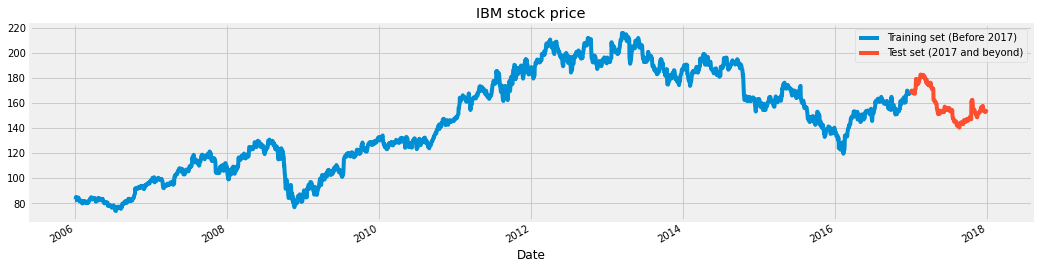

In [30]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
df["High"][:'2016'].plot(figsize=(16,4),legend=True)
df["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [31]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [91]:
# Since LSTMs store long term memory state, we create a data structure with 100 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(100,2769):
    X_train.append(training_set_scaled[i-100:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [92]:
X_train.shape

(2669, 100)

In [93]:
y_train.shape

(2669,)

In [94]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(2669, 100, 1)

In [95]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
84/84 [==============================] - 7s 88ms/step - loss: 0.0256
Epoch 2/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0050
Epoch 3/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0045
Epoch 4/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0039
Epoch 5/50
84/84 [==============================] - 7s 88ms/step - loss: 0.0040
Epoch 6/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0038
Epoch 7/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0037
Epoch 8/50
84/84 [==============================] - 7s 88ms/step - loss: 0.0033
Epoch 9/50
84/84 [==============================] - 7s 86ms/step - loss: 0.0034
Epoch 10/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0033
Epoch 11/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0032
Epoch 12/50
84/84 [==============================] - 7s 87ms/step - loss: 0.0031
Epoch 13/50
84/84 [==================

In [96]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 100 entires of test set have 100 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((df["High"][:'2016'],df["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set)-100:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs.shape

(350, 1)

In [98]:
X_test = []
for i in range(100,350):
    X_test.append(inputs[i-100:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

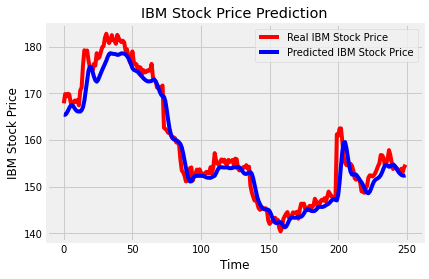

In [99]:
plt.plot(test_set, color='red',label='Real IBM Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [90]:
rmse = math.sqrt(mean_squared_error(test_set,predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 2.582263600327406.
